# Лабораторная работа №5

In [1]:
import csv
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

filename = '2_features/1.csv'
plt.rcParams["figure.figsize"] = (20,10)

Загружаем данные.

In [2]:
df = pd.read_csv(filename)
X = df.iloc[:, 0:2].to_numpy()
y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

SVC with linear kernel. Accuracy: Train 85.79%, Test 88.83%, Supported vectors: 826
SVC with polynomial (degree 2) kernel. Accuracy: Train 87.49%, Test 90.17%, Supported vectors: 726
SVC with polynomial (degree 3) kernel. Accuracy: Train 87.12%, Test 90.00%, Supported vectors: 759
SVC with RBF kernel. Accuracy: Train 88.37%, Test 89.33%, Supported vectors: 695


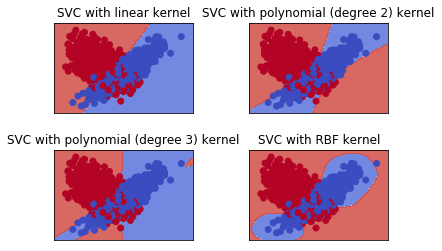

In [3]:
C = 1.0
svc = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=1.0, C=C).fit(X_train, y_train)
poly2_svc = svm.SVC(kernel='poly', degree=2, C=C).fit(X_train, y_train)
poly3_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X_train, y_train)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

titles = ['SVC with linear kernel',
          'SVC with polynomial (degree 2) kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with RBF kernel']

for i, clf in enumerate((svc, poly2_svc, poly3_svc, rbf_svc)):
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    SV_num = clf.support_.shape[0]
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    print('{}. Accuracy: Train {:.2f}%, Test {:.2f}%, Supported vectors: {}'.
          format(titles[i], 100*train_acc, 100*test_acc, SV_num))
plt.show()

Наилучшего показателя точности удалось добиться при использовании полиномиального ядра 2 порядка. Немного уступает в точности ядро 3-го порядка.

Радиальное RBF ядро уступает на тестовой выборке, но превосходит на обучающей и имеет самую низкую сложность, так как использует меньше всего опорных векторов.

Линейное ядро показывает худший по сравнению с другими результат и использует больше опорных векторов.

Судя по этому примеру, количество опорных векторов и качество напрямую не зависят.

In [4]:
def plot_rbf(ax, t, metrics, best_ind, x_label, title):
    ax.plot(t, metrics)
    ax.scatter(t[best_ind], metrics[best_ind], marker='o', color='red')
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.grid()

def find_best(C_params, sigma_params):
    acc_train = []
    acc_test = []
    for C in C_params:
        for sigma in sigma_params:
            gamma = 1 / (sigma ** 2)
            d = {'C': C, 'gamma': gamma}
            clf = svm.SVC(kernel='rbf', random_state=1, **d).fit(X_train, y_train)
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

    _, ax = plt.subplots(2, 1)
    
    x_label = 'C' if len(C_params) > 1 else r'$\sigma$'
    t = C_params if len(C_params) > 1 else sigma_params
    
    best_ind = np.argmax(acc_test)
    plot_rbf(ax[0], t, acc_train, best_ind, x_label, 'Train accuracy')
    plot_rbf(ax[1], t, acc_test, best_ind, x_label, 'Test accuracy')
    
    return best_ind

Best C: 0.025050505050505052


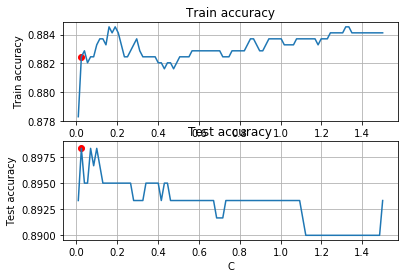

In [5]:
C_params = np.linspace(1e-2, 1.5, 100)
ind = find_best(C_params, [1.0])
best_C = C_params[ind]
print('Best C:', best_C)

Best sigma: 1.3645454545454545


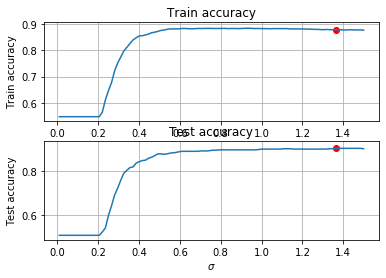

In [6]:
sigma_params = np.linspace(1e-2, 1.5, 100)
ind = find_best([best_C], sigma_params)
best_sigma = sigma_params[ind]
print('Best sigma:', best_sigma)

In [7]:
best_gamma = 1 / (best_sigma ** 2)

SVC with RBF kernel. Accuracy: Train 88.37%, Test 89.33%, Supported vectors: 695
SVC with optimal RBF kernel. Accuracy: Train 87.74%, Test 90.17%, Supported vectors: 1139


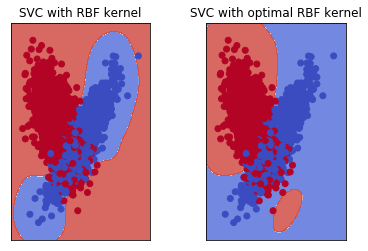

In [8]:
C = 1.0
rbf_svc = svm.SVC(kernel='rbf', gamma=1.0, C=C).fit(X_train, y_train)
best_rbf_svc = svm.SVC(kernel='rbf', gamma=best_gamma, C=best_C).fit(X_train, y_train)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

titles = ['SVC with RBF kernel',
          'SVC with optimal RBF kernel']

for i, clf in enumerate((rbf_svc, best_rbf_svc)):
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    SV_num = clf.support_.shape[0]
    plt.subplot(1, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    print('{}. Accuracy: Train {:.2f}%, Test {:.2f}%, Supported vectors: {}'.
          format(titles[i], 100*train_acc, 100*test_acc, SV_num))
plt.show()

Подобрав оптимальные параметры, удалось увеличить точность на тестовой выборке почти на 1%, но одновременно с этим, значетельно увеличилось количество опорных векторов. Также изменилось и разбиение. Область одного из классов значительно увеличилась.

Загрузим новые данные.

In [9]:
filename = 'nonlinear/1.csv'
df = pd.read_csv(filename)
X = df.iloc[:, 0].to_numpy().reshape((-1, 1))
y = df.iloc[:, 1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [10]:
def get_best_model(estimator, param_grid):
    grid_model = GridSearchCV(estimator, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_

    train_acc = mean_squared_error(y_train, best_model.predict(X_train))
    test_acc = mean_squared_error(y_test, best_model.predict(X_test))
    print('Best params: {}'.format(grid_model.best_params_))
    print('Train {:.6f}, Test {:.6f}'.format(train_acc, test_acc))
    
    return best_model

При помощи кросс-валидации будем искать оптимальные параметры ядра.

In [11]:
rbf_params = {
    'gamma': np.linspace(1, 5, 5),
    'C': np.linspace(0.1, 200, 10),
    'epsilon': np.linspace(1e-5, 1, 5)
}

model = get_best_model(svm.SVR(kernel='rbf'), rbf_params)

Best params: {'C': 200.0, 'epsilon': 1e-05, 'gamma': 5.0}
Train 0.000001, Test 0.000003


Получаем крайне малое отклонение

In [12]:
poly_params = {'gamma': np.linspace(1, 5, 10)}
model = get_best_model(svm.SVR(kernel='poly', degree=6, coef0=1, C=100, epsilon=0.1), poly_params)

Best params: {'gamma': 2.333333333333333}
Train 0.003946, Test 0.004887


In [13]:
C = 1.0
best_poly = svm.SVR(kernel='poly', degree=6, C=100, coef0=1, epsilon=0.01, gamma=2.333).fit(X_train, y_train)
best_rbf = svm.SVR(kernel='rbf', C=200, epsilon=0.000001, gamma=5.0).fit(X_train, y_train)

train_mse_poly = mean_squared_error(y_train, best_poly.predict(X_train))
test_mse_poly = mean_squared_error(y_test, best_poly.predict(X_test))
print('Poly: Train {:.6f}, Test {:.6f}'.format(train_mse_poly, test_mse_poly))

train_mse_rbf = mean_squared_error(y_train, best_rbf.predict(X_train))
test_mse_rbf = mean_squared_error(y_test, best_rbf.predict(X_test))
print('RBF: Train {:.6f}, Test {:.6f}'.format(train_mse_rbf, test_mse_rbf))


Poly: Train 0.002431, Test 0.004537
RBF: Train 0.000001, Test 0.000003


Как видим, для RBF ядра получили очень маленькую ошибку. В целом, полиномиальное ядро хоть и имеет гораздо большую по сравнению с RBF ядром ошибку, все равно показало неплохой результат. 

In [14]:
def fun(x):
    C = x[0]
    eps = x[1]
    if C < 1e-5:
        return np.inf
    if eps < 1e-6:
        return np.inf
    svr = svm.SVR(kernel='rbf', gamma=5.0, C=C, epsilon=eps)
    svr.fit(X_test, y_test)
    mse = mean_squared_error(y_test, svr.predict(X_test))
    
    return mse

x0 = [100, .1]

res = minimize(fun, x0, method='Nelder-Mead', options={'maxiter': 30, 'disp': True})
best_C, best_eps = res.x
print(f'Optimal params: C: {best_C}, eps: {best_eps}')

Optimal params: C: 147.149658203125, eps: 0.0010913085937501923


In [15]:
best_rbf = svm.SVR(kernel='rbf', gamma=5.0, C=best_C, epsilon=best_eps).fit(X_train, y_train)

train_mse_brbf = mean_squared_error(y_train, best_rbf.predict(X_train))
test_mse_brbf = mean_squared_error(y_test, best_rbf.predict(X_test))
print('RBF: Train {:.6f}, Test {:.6f}'.format(train_mse_brbf, test_mse_brbf))

RBF: Train 0.000002, Test 0.000004


При помощи этого метода не удалось уменьшить ошибку, но стоит обратить внимание, что ошибка после предыдущего метода уже была довольно маленькой.

RBF: Train 0.000002, Test 0.000004
Number of support vectors: 79


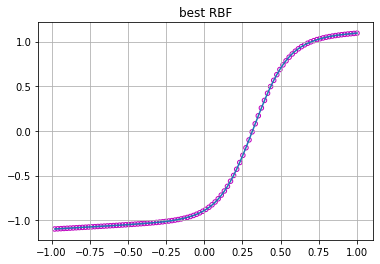

In [16]:
best_rbf = svm.SVR(kernel='rbf', C=200, epsilon=0.000001, gamma=5.0).fit(X_train, y_train)
train_mse = mean_squared_error(y_train, best_rbf.predict(X_train))
test_mse = mean_squared_error(y_test, best_rbf.predict(X_test))

x_min, x_max = X.min() - 1, X.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1

plt.scatter(X, y, s=20, facecolor="none", edgecolor='m')
plt.plot(X, best_rbf.predict(X))
plt.grid()

plt.title('best RBF')
print('RBF: Train {:.6f}, Test {:.6f}'.format(train_mse_brbf, test_mse_brbf))
print('Number of support vectors:', best_rbf.support_.size)
    

Как видим по графику, использование ядра RBF позволило очень хорошо апроксимировать ~~данные~~ данные.